#### facebook/timesformer-base-finetuned-k400

In [1]:

from transformers import AutoImageProcessor, TimesformerForVideoClassification
import numpy as np
import torch

video = list(np.random.randn(8, 3, 224, 224))

processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")

inputs = processor(video, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

/home/vai/Desktop/chat_bot_experiment_one/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-4.612899711239714, 4.526782851217135] which cannot be converted to uint8.

In [2]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-5lcfarw4
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-5lcfarw4
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ad410c9c0ae0d499aeec9a7af09b0636844b6274
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 1.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=29154 sha256=0ddca36d3ab7c326aa669577503c52cb129ae029cab17162867aeeda02cdaa08
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgf0djbw/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos-forecasting


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from chronos import ChronosPipeline

In [9]:
##https://finance.yahoo.com/quote/AAPL/history/
import pandas as pd

from datasets import load_dataset

ds = load_dataset("jettisonthenet/timeseries_trending_youtube_videos_2019-04-15_to_2020-04-15")

# apple_dataset = pd.read_csv("https://finance.yahoo.com/quote/AAPL/history/AAPL.csv")
print(ds)

# Display the first few rows of the 'train' dataset
print(ds['train'].to_pandas().head())

DatasetDict({
    train: Dataset({
        features: ['videostatsid', 'ytvideoid', 'views', 'comments', 'likes', 'dislikes', 'timestamp'],
        num_rows: 1541128
    })
})
   videostatsid    ytvideoid     views  comments   likes  dislikes  \
0             1  0GLbwkfhYZk   5722228     28229  185188     10860   
1             2  O4NB73HTlxI   3673770     31565  278477      4705   
2             3  VVRcXtSjPcE    253613      1025    4587        87   
3             4  adzYW5DZoWs  21567972     79208  478496     61703   
4             5  p_8yK2kmxoo   2385064     10703  133304      1323   

             timestamp  
0  2019-04-15 04:42:49  
1  2019-04-15 04:42:50  
2  2019-04-15 04:42:51  
3  2019-04-15 04:42:51  
4  2019-04-15 04:42:52  


In [11]:
test_size = 22
split_index = len(ds['train']) - test_size

# If the dataframe is shorter than 22 rows, all goes to test
if split_index < 0:
    train_views = pd.Series(dtype=float)
    test_views = ds['train']['views']
else:
    # Splitting the views column into training and test sets
    train_views = ds['train']['views'][:split_index]
    test_views = ds['train']['views'][split_index:]

In [10]:
# Ensure the accelerate package is installed
%pip install accelerate

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  torch_dtype=torch.bfloat16,
)

Note: you may need to restart the kernel to use updated packages.


NameError: name 'ChronosPipeline' is not defined

In [9]:
context = torch.tensor(test_views)
prediction_length = test_size
forecast = pipeline.predict(context, prediction_length)

NameError: name 'test_views' is not defined

In [8]:
forecast_index = range(len(test_views), len(test_views) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(test_views, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

NameError: name 'test_views' is not defined

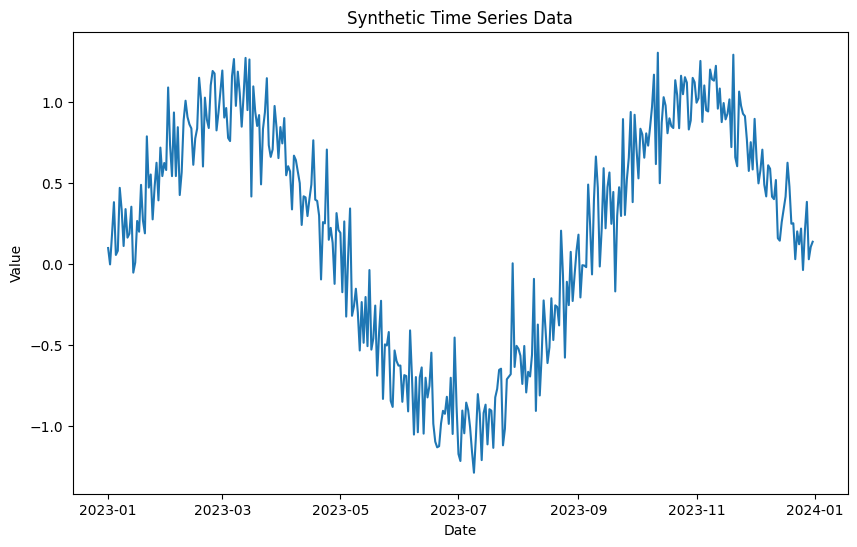

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data (e.g., daily temperatures)
np.random.seed(42)
n = 365  # 1 year of data
date_range = pd.date_range(start="2023-01-01", periods=n, freq="D")
data = np.sin(np.linspace(0, 3 * np.pi, n)) + 0.2 * np.random.randn(n)  # Sine wave with noise

# Create a DataFrame
df = pd.DataFrame({"date": date_range, "value": data})
df.set_index("date", inplace=True)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["value"])
plt.title("Synthetic Time Series Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


In [75]:
from datasets import Dataset
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from torch.utils.data import DataLoader

# Normalize the time series data
scaler = MinMaxScaler()
df["value_normalized"] = scaler.fit_transform(df[["value"]])

# Create a dataset for the model
# sequence_length = config.context_length  # Align with model config

# Define model configuration

config = TimeSeriesTransformerConfig(
    prediction_length=1,
    context_length=20,
    input_size=1,
    d_model=64,
    encoder_layers=2,
    decoder_layers=2,
    dropout=0.1,
    lags_sequence=[1],  # Reduced to fit within available history
)


# Required sequence length based on context_length and lags_sequence
required_sequence_length = config.context_length + (max(config.lags_sequence) if config.lags_sequence else 0)

features = []
targets = []
time_features = []
observed_mask = []

# Adjust the loop to ensure sufficient history
for i in range(len(df) - required_sequence_length):
    features.append(df["value_normalized"].iloc[i:i + config.context_length].values)
    targets.append(df["value_normalized"].iloc[i + config.context_length])
    time_features.append([[0.0]] * config.context_length)  # Dummy time features
    observed_mask.append([1] * config.context_length)      # Observed mask

print("Number of samples:", len(features))
print("First sample's past_values length:", len(features[0]))
print("Expected context_length:", config.context_length)


# Convert to a Hugging Face dataset
future_time_features = [[0.0]]  # Dummy future time feature for prediction length


dataset = Dataset.from_dict({
    "past_values": features,
    "future_values": targets,
    "past_time_features": time_features,
    "past_observed_mask": observed_mask,
    "future_time_features": [future_time_features] * len(features),  # Add dummy future features
})


# Split into train and validation sets
train_size = int(0.8 * len(dataset))
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, len(dataset)))


# Load the model
model = TimeSeriesTransformerForPrediction(config)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    remove_unused_columns=False
)

# Custom data collator
def custom_data_collator(features):
    return {
        "past_values": torch.tensor([f["past_values"] for f in features]).float(),
        "past_time_features": torch.tensor([f["past_time_features"] for f in features]).float(),
        "past_observed_mask": torch.tensor([f["past_observed_mask"] for f in features]).float(),
        "future_values": torch.tensor([f["future_values"] for f in features]).float().unsqueeze(-1),  # Add a second dimension
        "future_time_features": torch.tensor([f["future_time_features"] for f in features]).float(),
    }


# Use the custom data collator in the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_data_collator
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Predict future values
model.eval()  # Set model to evaluation mode

# Select a sample from the validation set
sample = torch.tensor([val_dataset[0]["past_values"]]).float()  # Reshape for model input
sample_time_features = torch.tensor([val_dataset[0]["past_time_features"]]).float()
sample_observed_mask = torch.tensor([val_dataset[0]["past_observed_mask"]]).float()

with torch.no_grad():
    outputs = model(
        past_values=sample,
        past_time_features=sample_time_features,
        past_observed_mask=sample_observed_mask
    )
    predictions = outputs.predictions.squeeze(0).numpy()  # Use 'predictions' field

# Reverse normalization
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(predictions):], predictions, label="Predictions", color="orange")
plt.plot(df.index[-len(predictions):], df["value"].values[-len(predictions):], label="Actual", color="blue")
plt.title("Time Series Forecasting - Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


/home/vai/Desktop/chat_bot_experiment_one/venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/170 [01:30<?, ?it/s]


Number of samples: 344
First sample's past_values length: 20
Expected context_length: 20


ValueError: lags cannot go further than history length, found lag 1 while history length is only 21

In [ ]:
print("Number of samples in dataset:", len(features))
print("First sample's past_values length:", len(features[0]))
print("Expected context_length:", config.context_length)


sample = train_dataset[0]
past_values = torch.tensor([sample["past_values"]]).float()
past_time_features = torch.tensor([sample["past_time_features"]]).float()
past_observed_mask = torch.tensor([sample["past_observed_mask"]]).float()
future_values = torch.tensor([sample["future_values"]]).float().unsqueeze(-1)  # Add second dimension
future_time_features = torch.tensor([sample["future_time_features"]]).float()

with torch.no_grad():
    outputs = model(
        past_values=past_values,
        past_time_features=past_time_features,
        past_observed_mask=past_observed_mask,
        future_values=future_values,
        future_time_features=future_time_features,
    )
    print(outputs)  




Number of samples in dataset: 336
First sample's past_values length: 28
Expected context_length: 28


ValueError: lags cannot go further than history length, found lag 1 while history length is only 29

In [66]:
class DebugTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        print("past_values shape:", inputs["past_values"].shape)
        print("past_time_features shape:", inputs["past_time_features"].shape)
        print("past_observed_mask shape:", inputs["past_observed_mask"].shape)
        print("future_values shape:", inputs["future_values"].shape)
        print("future_time_features shape:", inputs["future_time_features"].shape)
        return super().compute_loss(model, inputs, return_outputs)

trainer = DebugTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_data_collator,
)
trainer


In [20]:
print(dataset[0])


{'past_values': [0.5350059319633733, 0.4959762517562661, 0.5666431720196005, 0.6441979538178499, 0.5184880416392361, 0.5284163451215634, 0.6783100240588358, 0.6254901121487232, 0.5398012229997774, 0.6276892736258919, 0.559716510036049, 0.5691657086027336, 0.6333582102346724, 0.47643812942101493, 0.5003710914461919, 0.5994308465520647, 0.573847172553298, 0.6854010170298197, 0.6000215036347157, 0.5699584088152521, 0.8008990216522038, 0.6789317793121867, 0.7100621252576333, 0.6031967560031695, 0.6793665406676925, 0.7380098508733179, 0.6484776173139266, 0.7740790869952894, 0.7062671976245876, 0.7375141456085308], 'future_values': 0.7207977653480439, 'past_time_features': [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], 'past_observed_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [22]:
print(train_dataset[0])
print(val_dataset[0])


{'past_values': [0.5350059319633733, 0.4959762517562661, 0.5666431720196005, 0.6441979538178499, 0.5184880416392361, 0.5284163451215634, 0.6783100240588358, 0.6254901121487232, 0.5398012229997774, 0.6276892736258919, 0.559716510036049, 0.5691657086027336, 0.6333582102346724, 0.47643812942101493, 0.5003710914461919, 0.5994308465520647, 0.573847172553298, 0.6854010170298197, 0.6000215036347157, 0.5699584088152521, 0.8008990216522038, 0.6789317793121867, 0.7100621252576333, 0.6031967560031695, 0.6793665406676925, 0.7380098508733179, 0.6484776173139266, 0.7740790869952894, 0.7062671976245876, 0.7375141456085308], 'future_values': 0.7207977653480439, 'past_time_features': [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], 'past_observed_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [44]:
class DebugTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        print("past_values shape:", inputs["past_values"].shape)
        print("future_values shape:", inputs["future_values"].shape)
        return super().compute_loss(model, inputs, return_outputs)

trainer = DebugTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_data_collator
)


In [45]:
sample = train_dataset[0]
past_values = torch.tensor([sample["past_values"]]).float()
past_time_features = torch.tensor([sample["past_time_features"]]).float()
past_observed_mask = torch.tensor([sample["past_observed_mask"]]).float()
future_values = torch.tensor([sample["future_values"]]).float().unsqueeze(-1)  # Add second dimension
future_time_features = torch.tensor([sample["future_time_features"]]).float()

with torch.no_grad():
    outputs = model(
        past_values=past_values,
        past_time_features=past_time_features,
        past_observed_mask=past_observed_mask,
        future_values=future_values,
        future_time_features=future_time_features,
    )
    print(outputs)


ValueError: lags cannot go further than history length, found lag 5 while history length is only 31